In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pygame
import time

pygame 2.6.1 (SDL 2.28.4, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#подготовка даннных 
def load_and_prepare_data(filepath, sep=';'):
    data = pd.read_csv(filepath, sep=sep)
    data = data.replace(',', '.', regex=True).astype(float)
    data = data.sample(frac=0.001, random_state=42)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return dataset, X.shape[1], len(np.unique(y)), scaler

In [3]:
#архитектура нейронной сети
#здесь нужно вводить чуть дальше параметры
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
#функция обучения одной модели
def train_model(model, train_loader, num_epochs=20): #20 эпох
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        for data, labels in train_loader:
            optimizer.zero_grad() #анулируем градиент
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [5]:
#обучаем ансамбль моделей 
def train_ensemble(models, dataset, sample_size=0.8, num_epochs=20):
    for model in models:
        sample_indices = torch.randperm(len(dataset))[:int(sample_size * len(dataset))]
        subset = Subset(dataset, sample_indices)
        train_loader = DataLoader(subset, batch_size=16, shuffle=True)
        train_model(model, train_loader, num_epochs)

In [6]:
#метрика оценки качества работы
def calculate_accuracy(models, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in data_loader:
            predictions = ensemble_predict(models, data)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [7]:
#перелизменение данных
def preprocess_input(user_input, scaler):
    processed_input = np.array(user_input).reshape(1, -1)
    processed_input = scaler.transform(processed_input)
    return torch.tensor(processed_input, dtype=torch.float32)

In [8]:
#роза ветров
def plot_wind_rose(predictions):
    angles = np.deg2rad(np.linspace(0, 360, len(predictions), endpoint=False))
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.bar(angles, predictions, width=np.deg2rad(360 / len(predictions)), color='skyblue', edgecolor='black')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    angles_ticks = np.linspace(0, 2 * np.pi, len(directions), endpoint=False)
    ax.set_xticks(angles_ticks)
    ax.set_xticklabels(directions)
    plt.title("Wind Rose - Predictions", fontsize=16)
    plt.show()

In [9]:
#предиктим куда дальше пойдут газы
def ensemble_predict_value(models, processed_input):
    predictions = [model(processed_input).item() for model in models]
    return sum(predictions) / len(predictions)


In [10]:
class DummyModel:
    def __call__(self, x):
        return torch.sum(x)

In [12]:
#тепловая карта с указанием концентрации газов через определенные промежутки времени
def initialize_grid():
    grid = np.zeros((10, 20), dtype=int)
    grid[5, 10] = 1
    return grid

def update_grid(grid):
    new_grid = grid.copy()
    for y in range(1, 9):
        for x in range(1, 19):
            if grid[y, x] == 1:
                if np.random.rand() < 0.1:
                    new_grid[y + np.random.randint(-1, 2), x + np.random.randint(-1, 2)] = 1
    return new_grid

def draw_grid(screen, grid):
    screen.fill((0, 0, 0))
    for y in range(10):
        for x in range(20):
            if grid[y, x] == 1:
                pygame.draw.rect(screen, (255, 255, 255), (x * 20, y * 20, 20, 20))
    pygame.display.flip()
def main_ca():
    pygame.init()
    screen = pygame.display.set_mode((20 * 20, 10 * 20))
    pygame.display.set_caption("Cellular Automata")
    grid = initialize_grid()
    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        grid = update_grid(grid)
        draw_grid(screen, grid)
        time.sleep(1)
    pygame.quit()


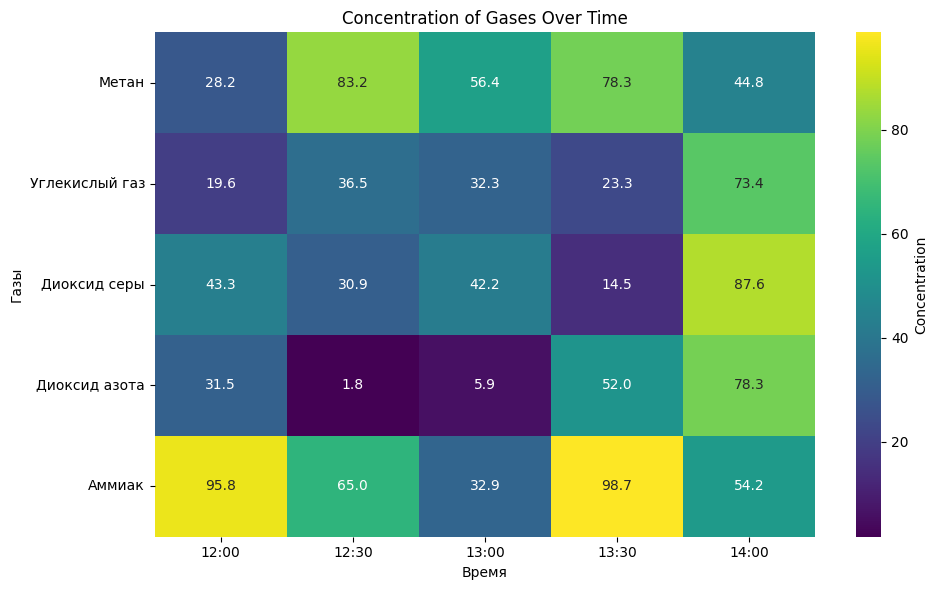

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Пример данных: концентрация газов в разные моменты времени
# Создаем DataFrame с данными
times = ['12:00', '12:30', '13:00', '13:30', '14:00']
gases = ['Метан', 'Углекислый газ', 'Диоксид серы', 'Диоксид азота', 'Аммиак']

# Случайные данные для примера
data = np.random.rand(len(gases), len(times)) * 100  # Концентрация от 0 до 100

# Создаем DataFrame
df = pd.DataFrame(data, index=gases, columns=times)

# Создаем тепловую карту
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, fmt=".1f", cmap='viridis', cbar_kws={'label': 'Concentration'})
plt.title('Concentration of Gases Over Time')
plt.xlabel('Время')
plt.ylabel('Газы')
plt.tight_layout()
plt.show()